In [9]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *


from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function

In [10]:
inFile = 'corrected_mags_linewidth_all.csv'

table   = np.genfromtxt(inFile , delimiter='|', filling_values=-99999, names=True, dtype=None, encoding=None)

pgc  = table['pgc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

P0_w2 = table['P0_w2']
P0_w1 = table['P0_w1']

N = len(Sqlt)
q = np.zeros(N)

q[np.where(Sqlt>3)]+=1
q[np.where(Wqlt>3)]+=1
indx, = np.where(q==2)

In [11]:
PC_w1 = P0_w1[indx]
PC_w2 = P0_w2[indx]
N = len(PC_w2)
err = np.zeros(N)+0.01

M,B,samples=linMC(PC_w1, PC_w2, err, err)
m = M[0] ; me=0.5*(M[1]+M[2])
b = B[0] ; be=0.5*(B[1]+B[2])

1.0193283611352273 -0.06788331016475896


(-3.5, 3.5)

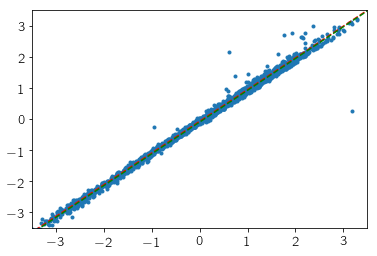

In [12]:
plt.plot(PC_w1,PC_w2, '.') 
x_ = np.linspace(-4,15,50)
plt.plot(x_, m*x_+b, 'r--') 

plt.plot(x_, 1.021*x_-0.094, 'g--') 
print m,b

plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)